## Produce flat ntuples

In [1]:
import ROOT
from root_numpy import root2array
import numpy as np
import sys, os
import pickle
from collections import Counter
from matplotlib import pyplot as plt
from array import array

## Should load CMS-SW environment before running this notebook
from DataFormats.FWLite import Handle, Events
ROOT.gSystem.Load("libFWCoreFWLite.so")
ROOT.gSystem.Load("libDataFormatsFWLite.so")
ROOT.gSystem.Load("libDataFormatsPatCandidates.so")
def toVec(arr):
    if len(arr)==4:
        return ROOT.TLorentzVector(arr[0],arr[1],arr[2],arr[3])
    elif len(arr)==3:
        return ROOT.TVector3(arr[0],arr[1],arr[2])
def vec2array(v, dim=4):
    if 'ROOT::Math::PxPyPzE4D' in str(type(v)):
        if dim==4: return (v.px(), v.py(), v.pz(), v.energy())
        if dim==3: return (v.px(), v.py(), v.pz())
    if 'TLorentzVector' in str(type(v)):
        if dim==4: return (v.Px(), v.Py(), v.Pz(), v.E())
        if dim==3: return (v.Px(), v.Py(), v.Pz())
    else:
        print('Wrong format!'); exit(1)
def wgtarr(n):
    return [1./n] * n
# class mydict(dict):
#     def appendto(self, key, value):
#         if not self.has_key(key):
#             self[key] = []
#         elif type(self[key]) != type([]):
#             print type(self[key])
#             print ("Wrong format for key: '{key}', will overload".format(key=key))
#             self[key] = []
#         self[key].append(value)
def fill_lvector(p, dic, key, append=True, m=False):
    snlist = ['pt', 'eta', 'phi', 'e', 'mass'] # here we change m to mass
    if hasattr(p, 'pt'):
        attrlist = ['pt', 'eta', 'phi', 'energy', 'm']
    elif hasattr(p, 'Pt'):
        attrlist = ['Pt', 'Eta', 'Phi', 'E', 'M']
    else:
        print ("Somthing is wrong.. Probably not a Lorentz vector?")
    
    for i in range(5) if m==True else range(4):
        if append:
            dic[key+'_'+snlist[i]].append(getattr(p, attrlist[i])())
        else:
            dic[key+'_'+snlist[i]] = getattr(p, attrlist[i])()
def init_dict(dic, varlist):
    for var in varlist:
        varname, vartype = var.split('/')[0], var.split('/')[-1]
        if vartype == 'vi' or vartype == 'vf':
            dic[varname] = []
        elif vartype == 'vtl' or vartype == 'vtlm':
            for sn in (['pt','eta','phi','e','mass'] if vartype[-1]=='m' else ['pt','eta','phi','e']):
                dic[varname+'_'+sn] = []            
def dictoVec(dic, key, index, ptetaphie=True):
    if not isinstance(dic[key+'_pt'], list):
        ar = [dic[key+'_pt'], dic[key+'_eta'], dic[key+'_phi'], dic[key+'_e']]
    else:
        ar = [dic[key+'_pt'][index], dic[key+'_eta'][index], dic[key+'_phi'][index], dic[key+'_e'][index]]
    lv = ROOT.TLorentzVector()
    lv.SetPtEtaPhiE(*ar)
    return lv

Welcome to JupyROOT 6.18/04


In [2]:
# inputDir, outputFile = '/eos/user/c/coli/crab_output/TEST/crab_dy012_T_clusinfo/200624_150410/0000', 'dy012_T_clusinfo_LHEGEN.root'
inputDir, outputFile = '/eos/user/c/coli/crab_output/TEST/crab_dy012_F_clusinfo/200624_153405/0000/', 'dy012_F_clusinfo_LHEGEN.root'
isAutoDelete = True
outputVariable = ['LHEPart_pdgId/vi',
                  'LHEPart/vtlm', 'nLHEPart/i',
                  'nMEPartons/i', 'DJRValues/vf',
                  'genjet/vtlm',
                 ]

### Start self-defined series
genparticle_ = Handle('std::vector<reco::GenParticle>')
geninfo_ = Handle('GenEventInfoProduct')
genjets_ = Handle('std::vector<reco::GenJet>')
lheinfo_ = Handle('LHEEventProduct')

def calculateNewVariable(event):
    event.getByLabel("genParticles", genparticle_)
    event.getByLabel("ak4GenJets", genjets_)
    event.getByLabel("generator", geninfo_)
    event.getByLabel("externalLHEProducer", lheinfo_)
    genparticle = genparticle_.product()
    geninfo = geninfo_.product()
    genjets = genjets_.product()
    lheinfo = lheinfo_.product()
    
    dic = {}; init_dict(dic, outputVariable)
    
    vp4 = [toVec([lheinfo.hepeup().PUP[ip][i] for i in range(4)]) for ip in range(lheinfo.hepeup().NUP)]
    vid = [lheinfo.hepeup().IDUP[ip] for ip in range(lheinfo.hepeup().NUP)]
    for ip in range(2, len(vid)):
        dic['LHEPart_pdgId'].append(vid[ip])
        fill_lvector(p=vp4[ip], dic=dic, key='LHEPart', append=True, m=True)
    dic['nLHEPart'] = len(vid)-2
    
    dic['nMEPartons'] = geninfo.nMEPartons()
    dic['DJRValues'] = [geninfo.DJRValues().at(ii) for ii in range(geninfo.DJRValues().size())]
    
    for i in range(genjets.size()):
        jet = genjets.at(i)
        jetv = ROOT.TLorentzVector(jet.px(), jet.py(), jet.pz(), jet.energy())
        fill_lvector(p=jetv, dic=dic, key='genjet', append=True, m=True)

    return dic

In [3]:
# Create output file
if os.path.exists(os.path.join('output', outputFile)):
    print ("Warning: output file 'output/{outputFile}' exists".format(outputFile=outputFile))
    if isAutoDelete == False:
        sys.exit()
        
# ROOT.ROOT.EnableImplicitMT(8)
# ROOT.ROOT.DisableImplicitMT()
fnew = ROOT.TFile(os.path.join('output', outputFile), 'recreate')
tnew = ROOT.TTree('Events', 'Events')

# Setup File chain
filelist = []
for fname in os.listdir(inputDir):
    if ".root" in fname and 'inLHE' not in fname:
        filelist.append(os.path.join(inputDir, fname))
import re
# fileidx = ([i[0] for i in sorted(enumerate(int(re.split('_|\.', v)[-2]) for v in filelist), key=lambda k: k[1])])
# filelist = list(np.array(filelist)[fileidx])

# filelist = filelist[:1]
events = Events(filelist) # like a ROOT TChain
print "Add files: "
print filelist[0]
# print [int(re.split('_|\.', v)[-2]) for v in filelist]

# Set branches according to variables in configs
dic = {}
for var in outputVariable:
    varname, vartype = var.split('/')[0], var.split('/')[-1]
    if vartype == 'i':
        dic[varname] = array('i', [1])
        tnew.Branch(varname, dic[varname], varname+'/I')
    elif vartype == 'f':
        dic[varname] = array('f', [1])
        tnew.Branch(varname, dic[varname], varname+'/F')
    elif vartype == 'vi':
        dic[varname] = ROOT.vector('int')()
        tnew.Branch(varname, 'vector<int>', dic[varname])
    elif vartype == 'vf':
        dic[varname] = ROOT.vector('float')()
        tnew.Branch(varname, 'vector<float>', dic[varname])
    elif vartype == 'tl' or vartype == 'tlm':
        for sn in (['pt','eta','phi','e','mass'] if vartype[-1]=='m' else ['pt','eta','phi','e']):
            dic[varname+'_'+sn] = array('f', [1])
            tnew.Branch(varname+'_'+sn, dic[varname+'_'+sn], varname+'_'+sn+'/F')
    elif vartype == 'vtl' or vartype == 'vtlm':
        for sn in (['pt','eta','phi','e','mass'] if vartype[-1]=='m' else ['pt','eta','phi','e']):
            dic[varname+'_'+sn] = ROOT.vector('float')()
            tnew.Branch(varname+'_'+sn, 'vector<float>', dic[varname+'_'+sn])
    else:
        print ("Wrong outputVariable syntax: '{var}'".format(var=var))

# Start looping events
nevt = events.size()
for ie, event in enumerate(events): # loop over event
    if ie % 2000 == 0:
        print ('[' + int(30.*ie/nevt)*'>' + (30-int(30.*ie/nevt))*' ' + ']' + '%8d / %8d'%(ie, nevt))
    temp_dic = calculateNewVariable(event)
    if temp_dic == 'Error':
        print 'event error ', ie
        continue
    # fill in dic:
    for var in outputVariable:
        varname, vartype = var.split('/')[0], var.split('/')[-1]
        if vartype == 'i' or vartype == 'f':
            dic[varname][0] = temp_dic[varname]
        elif vartype == 'vi' or vartype == 'vf':
            dic[varname].clear()
            for elem in temp_dic[varname]:
                dic[varname].push_back(elem)
        elif vartype == 'tl' or vartype == 'tlm':
            for sn in (['pt', 'eta', 'phi', 'e', 'mass'] if vartype[-1]=='m' else ['pt', 'eta', 'phi', 'e']):
                dic[varname+'_'+sn][0] = temp_dic[varname+'_'+sn]
        elif vartype == 'vtl' or vartype == 'vtlm':
            for sn in (['pt', 'eta', 'phi', 'e', 'mass'] if vartype[-1]=='m' else ['pt', 'eta', 'phi', 'e']):
                dic[varname+'_'+sn].clear()
                for elem in temp_dic[varname+'_'+sn]:
                    dic[varname+'_'+sn].push_back(elem)
    tnew.Fill()
    if ie<1:
        print temp_dic
#     else:
#         break
fnew.Write()
fnew.Close()
print ('Done!')

Add files: 
/eos/user/c/coli/crab_output/TEST/crab_dy012_F_clusinfo/200624_153405/0000/B2G-RunIIFall17wmLHEGS-00072_1.root
[                              ]       0 /    57236
{'nMEPartons': 2, 'LHEPart_phi': [-2.8506807873667555, -2.0479476037536712, -2.9709781305533274, -2.621543052301797, 0.3293927902495639], 'genjet_pt': [278.6378173828125, 208.2073516845703, 42.59323501586914, 35.48808288574219, 15.227288246154783, 10.748863220214844, 8.307085037231445, 7.036545753479005, 6.712460994720459, 5.750887393951415, 5.388524532318115, 4.760395526885986, 4.201478004455566, 3.656618118286133, 3.6384830474853516, 3.6197562217712402, 3.555114030838013, 3.510179281234741, 3.363749742507934, 3.2441549301147456, 3.2010881900787354, 3.166622638702393, 3.154200077056885], 'genjet_mass': [20.614255905149868, 8.22731113434363, 4.241312980651802, 7.2517580986020285, 6.903861999511731, 2.808763027191162, 3.745598793029787, 2.5432801246643053, 2.973938941955576, 2.2153966426849236, 1.7513091564178427, 

## Make plots

In [4]:
import uproot
from uproot_methods import TLorentzVectorArray, TLorentzVector

In [5]:
import numpy as np
import boost_histogram as bh
from matplotlib import pyplot as plt
from matplotlib import gridspec
import mplhep as hep
plt.style.use(hep.style.ROOT)

import matplotlib as mpl
from cycler import cycler
# mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

def get_hist(array, bins=10, xmin=None, xmax=None, underflow=False, overflow=False, 
            weights=None, normed=False, **kwargs):
    r"""Plot histogram from input array.

    Arguments:
        array (np.ndarray): input array.
        bins (int, list or tuple of numbers, np.ndarray, bh.axis): bins
        weights (None, or np.ndarray): weights
        normed (bool): normalize the histogram to 1.

    Returns:
        hist (boost_histogram.Histogram)
    """

    if isinstance(bins, int):
        if xmin is None:
            xmin = array.min()
        if xmax is None:
            xmax = array.max()
        bins = bh.axis.Regular(bins, xmin, xmax, underflow=underflow, overflow=overflow)
    elif isinstance(bins, (list, tuple, np.ndarray)):
        bins = bh.axis.Variable(bins, underflow=underflow, overflow=overflow)

    hist = bh.Histogram(bins, storage=bh.storage.Weight())
    if weights is None:
        weights = np.ones_like(array)
        print(weights)
    hist.fill(array, weight=weights)
    if normed:
        histsum = hist.sum().value
        if histsum != 0:
            hist = hist / histsum
#     content = hist.view().value
#     err = np.sqrt(hist.view().variance)
#     edges = hist.axes[0].edges
    return hist


def plot_hist(hists, **kwargs):
    if not isinstance(hists, (list, tuple)):
        hists = [hists]
    content = [h.view().value for h in hists]
    bins = hists[0].axes[0].edges
    if 'yerr' in kwargs:
        yerr = kwargs.pop('yerr')
    else:
        yerr = [np.sqrt(h.view().variance) for h in hists]
    if len(hists) == 1:
        content, yerr = content[0], yerr[0]
    hep.histplot(content, bins=bins, yerr=yerr, **kwargs)

/cvmfs/cms.cern.ch/slc7_amd64_gcc820/lcg/root/6.18.04-bcolbf4/lib/ROOT.py:533: DeprecationWarning: Python 2 has reached EOL. mplhep is in a deprecated mode. Please switch to Python 3.
  return _orig_ihook( name, *args, **kwds )


In [6]:
df = {}
df['T'] = uproot.open("output/dy012_T_clusinfo_LHEGEN.root")['Events'].pandas.df(flatten=False)
df['F'] = uproot.open("output/dy012_F_clusinfo_LHEGEN.root")['Events'].pandas.df(flatten=False)

In [7]:
df['T']

,LHEPart_pdgId,LHEPart_pt,LHEPart_eta,LHEPart_phi,LHEPart_e,LHEPart_mass,nLHEPart,nMEPartons,DJRValues,genjet_pt,genjet_eta,genjet_phi,genjet_e,genjet_mass
entry,,,,,,,,,,,,,,
0,"[23, -13, 13, 21, 3]","[195.07275, 32.107586, 165.43098, 217.20505, 2...","[2.5473814, 1.5579456, 2.6504095, 1.1624262, 1...","[1.4629699, 1.8245001, 1.3942671, -1.7079542, ...","[1256.7, 79.62076, 1177.0792, 381.23926, 54.35...","[89.23828, 0.00016894308, -0.0051226825, -0.00...",5,2,"[215.67238, 22.600441, 14.649022, 8.6130705, 5...","[204.67676, 168.30113, 32.900803, 20.785326, 3...","[1.1667672, 2.6430373, 1.5606419, 1.4380122, 1...","[-1.7177464, 1.3970745, 1.827749, 1.2044159, -...","[362.44376, 1188.7941, 81.81363, 46.466885, 7....","[37.152523, 1.5448815, 1.9915512, 4.541941, 0...."
1,"[23, -11, 11, 1, -2]","[134.41411, 52.811657, 91.05544, 171.31732, 30...","[-1.2689488, -1.748097, -0.7348634, -0.5783403...","[1.6837686, 1.1995497, 1.9571589, 1.7003244, -...","[273.0316, 156.26352, 116.76805, 200.77577, 32...","[89.46836, 0.0013222137, 0.00078841817, 0.0013...",5,2,"[296.2106, 160.48257, 20.929235, 11.855601, 10...","[284.5203, 156.66922, 93.08691, 52.545746, 7.2...","[-0.3043862, -0.4507247, -0.7343336, -1.756219...","[-1.4742523, 1.6594512, 1.9690827, 1.2322392, ...","[299.63892, 173.56125, 119.39426, 156.67046, 7...","[33.119457, 15.648605, 3.8058064, 0.0005110021..."
2,"[-15, 15, 1, -1]","[210.81914, 27.345108, 390.14178, 211.1781]","[-2.7002296, -3.9395115, -0.48754328, -0.30528...","[1.6787202, -2.395034, -1.0507538, 2.368066]","[1575.9097, 702.94855, 437.4356, 221.09541]","[1.7770677, 1.777, -0.0023442735, 0.0015366318]",4,2,"[415.49707, 223.96376, 61.021748, 10.166015, 9...","[360.62766, 222.68475, 209.52269, 66.28304, 32...","[-0.41734445, -0.38001844, -2.7245443, -0.0973...","[-0.9820723, 2.2689605, 1.7248967, -1.7615234,...","[393.44388, 240.57309, 1604.4264, 67.73573, 69...","[27.343365, 27.8245, 2.7208097, 12.367472, 1.8..."
3,"[23, -13, 13, 2, -1]","[119.4974, 42.37251, 83.95412, 157.06644, 244....","[1.7020216, 2.3276012, 1.0229851, 0.90120476, ...","[-1.5970756, -1.1266445, -1.8278899, -0.610491...","[351.1458, 219.29564, 131.85017, 225.28418, 87...","[92.9649, -0.0011266926, -0.0012101491, -0.000...",5,2,"[262.82172, 139.6135, 91.228676, 47.489796, 36...","[267.1804, 132.05927, 80.67637, 72.8623, 30.71...","[-1.8460933, 1.0732163, 1.8165734, 1.1661265, ...","[2.2433023, -0.5240681, -1.0915277, -2.0044785...","[867.5827, 216.64252, 255.03423, 128.511, 32.4...","[18.549747, 20.2123, 13.659176, 7.7351665, 6.0..."
4,"[23, -11, 11, 21, 2]","[25.610825, 35.223972, 52.153934, 125.089066, ...","[4.721504, 3.9355597, 3.0276322, 0.033522412, ...","[2.6185474, -1.6199341, 1.9738561, 2.0242908, ...","[1441.6232, 901.9156, 539.7076, 125.159355, 49...","[92.73763, -0.002563522, -0.001435239, 0.00045...",5,2,"[128.47702, 112.59661, 97.30008, 68.63981, 20....","[128.38084, 96.87162, 85.36796, 71.97809, 53.5...","[1.8386686, -0.5134589, 0.3902415, 0.75967723,...","[-0.93739873, -2.4667113, 0.95509464, 2.300063...","[413.91647, 110.7154, 92.45407, 95.02286, 552....","[7.538131, 13.211944, 9.63023, 15.404034, 7.65..."
5,"[23, -15, 15, 2, -2]","[238.61443, 123.35422, 122.32302, 101.600975, ...","[-0.30307227, -0.012710904, -0.55805445, -1.19...","[2.47673, 2.7160664, 2.2353363, 0.1644521, -1....","[265.2578, 123.376976, 141.88083, 183.0157, 25...","[89.626785, 1.7770002, 1.7769996, 0.0012416063...",5,2,"[191.67342, 77.13469, 24.930061, 19.662222, 12...","[154.71324, 125.318634, 123.53553, 76.70096, 3...","[-0.9904302, -0.5380238, -0.0027575116, -0.537...","[-1.1043519, 2.1970847, 2.678311, 0.40541053, ...","[238.02863, 143.96257, 123.55192, 89.98522, 42...","[22.041119, 4.298603, 1.9834546, 18.606844, 5...."
6,"[23, -15, 15, 21, 2]","[201.16014, 192.75444, 26.714945, 44.015144, 2...","[-2.0869398, -2.037496, -1.7099783, -1.9089853...","[-1.5657302, -1.6945978, -0.37876186, -2.32908...","[828.1992, 751.9112, 76.28802, 151.73056, 860....","[91.085

In [8]:
sl = ['T', 'F']
for sam in sl:
    df[sam]['lhe_has_z'] = df[sam]['LHEPart_pdgId'].map(lambda x: x[0]==23)
    df[sam]['lhe_ptj1'] = df[sam].apply(lambda r: r['LHEPart_pt'][3] if (r['lhe_has_z'] and r['nLHEPart']>=4) else (r['LHEPart_pt'][2] if (not r['lhe_has_z'] and r['nLHEPart']>=3) else -1.), axis=1)
    df[sam]['lhe_ptj2'] = df[sam].apply(lambda r: r['LHEPart_pt'][4] if (r['lhe_has_z'] and r['nLHEPart']>=5) else (r['LHEPart_pt'][3] if (not r['lhe_has_z'] and r['nLHEPart']>=4) else -1.), axis=1)
    df[sam]['ptj1'] = df[sam]['genjet_pt'].map(lambda x: x[0] if len(x>0) else -1.)
    df[sam]['ptj2'] = df[sam]['genjet_pt'].map(lambda x: x[1] if len(x>1) else -1.)

In [9]:
bininfo = [ #(vname, nbin, xmin, xmax, label)
    ('lhe_ptj1', 40, 0, 400, r'LHE $p_{T,j1}$ [GeV]'),
    ('lhe_ptj2', 40, 0, 400, r'LHE $p_{T,j2}$ [GeV]'),
    ('ptj1', 40, 0, 400, r'GEN $p_{T,j1}$ [GeV]'),
    ('ptj2', 40, 0, 400, r'GEN $p_{T,j2}$ [GeV]'),
]

/cvmfs/cms.cern.ch/slc7_amd64_gcc820/external/py2-ipykernel/4.10.1-nmpfii2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in divide
/cvmfs/cms.cern.ch/slc7_amd64_gcc820/external/py2-ipykernel/4.10.1-nmpfii2/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in divide
/afs/cern.ch/user/c/coli/.local/lib/python2.7/site-packages/matplotlib/cbook/__init__.py:2484: UserWarning: Saw kwargs [u'ls', u'linestyle'] which are all aliases for u'linestyle'.  Kept value from u'linestyle'
  seen=seen, canon=canonical, used=seen[-1]))
/afs/cern.ch/user/c/coli/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family [u'cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


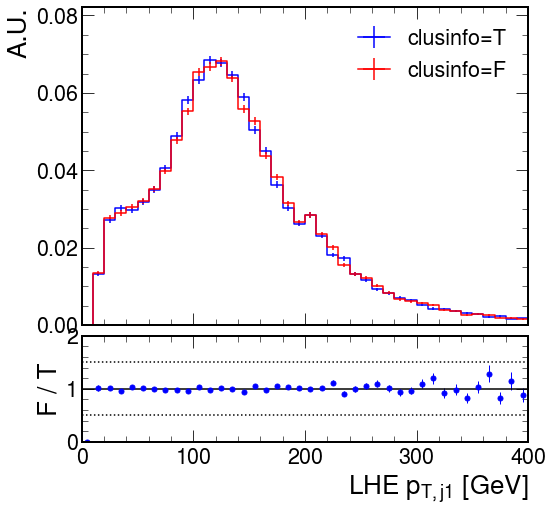

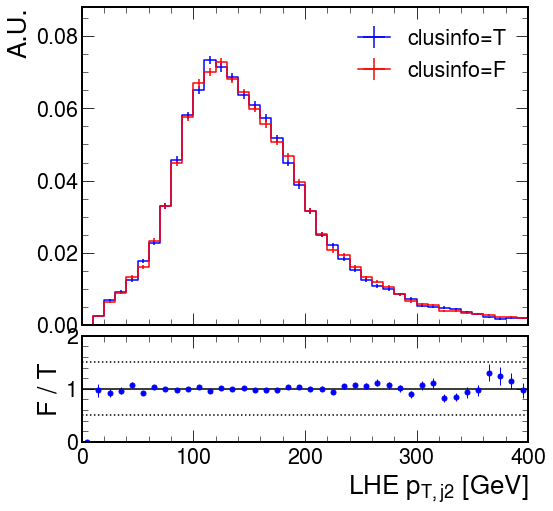

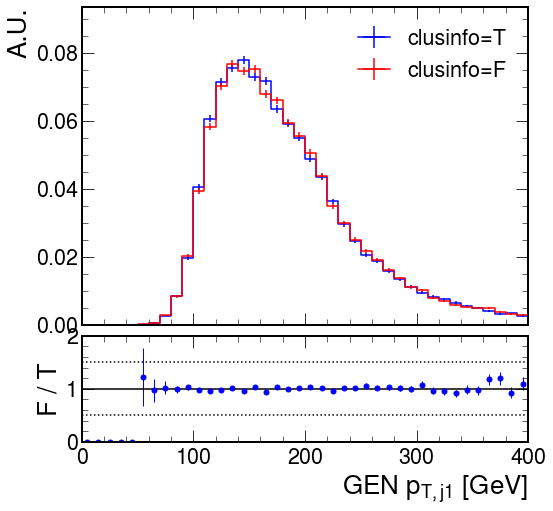

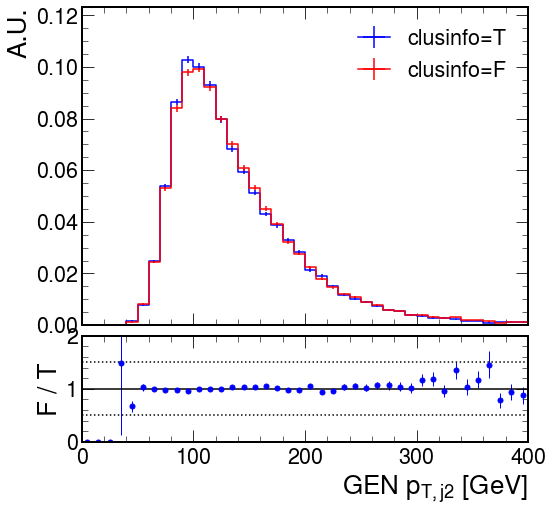

In [10]:
mpl.rcParams['axes.prop_cycle'] = cycler(color=['blue', 'red', 'violet', 'darkorange', 'green', 'black', 'cyan'])
label = {'T': 'clusinfo=T', 'F': 'clusinfo=F'}
for vname, nbin, xmin, xmax, vlabel in bininfo:
    f = plt.figure(figsize=(8,8))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.05) 
    ax = f.add_subplot(gs[0])
    ax.set_xlim(xmin, xmax); ax.set_xticklabels([]); ax.set_ylabel('A.U.', ha='right', y=1.0)
    h = {}
    
    for sam in sl:
        h[sam] = get_hist(df[sam][vname].values, bins=np.linspace(xmin, xmax, nbin+1), weights=np.ones(df[sam].shape[0]), normed=True)
        plot_hist(h[sam], label=label[sam])
    ax.legend()
    
    ax1 = f.add_subplot(gs[1]); ax1.set_xlim(xmin, xmax); ax1.set_ylim(0, 2)
    ax1.set_xlabel(vlabel, ha='right', x=1.0); ax1.set_ylabel('F / T', ha='center')
    ax1.plot([xmin,xmax], [1,1], 'k'); ax1.plot([xmin,xmax], [0.5,0.5], 'k:'); ax1.plot([xmin,xmax], [1.5,1.5], 'k:')

    for sam in sl[1:]:
        hr = h[sam].view().value / h[sl[0]].view().value
        hr_err = hr * np.sqrt(h[sam].view().variance/(h[sam].view().value**2) + h[sl[0]].view().variance/(h[sl[0]].view().value**2))
        hep.histplot(np.nan_to_num(hr), bins=h[sam].axes[0].edges, yerr=np.nan_to_num(hr_err), histtype='errorbar', color='blue')
    
#     plt.savefig(vname+'.pdf')